<span style="color:red">**If you already visited **<span> [**Part1-EDA**](https://www.kaggle.com/gauravsharma99/eda-on-mpg-data/)<span>** then you can directly jump to **<span>[this cell](#stats_analysis_beginning).

This is a 3 part series in which I will walk through a dataset analysing it and then at the end do predictive modelling. I highly recommend to follow this series in the order given below but you can also jump to any part by cliking on the heading links in blue.

[**Part 1, Exploratory Data Analysis(EDA):**](https://www.kaggle.com/gauravsharma99/eda-on-mpg-data/)<br>
This part consists of summary statistics of data but the major focus will be on EDA where we extract meaning/information from data using plots and report important insights about data. This part is more about **data analysis** and **business intelligence(BI)**.

**Part 2, Statistical Analysis:**<br>
In this part we will do many statistical hypothesis testing, apply estimation statistics and interpret the results we get. We will also validate this with the findings from part one. We will apply both parametric and non-parametric tests. We will report all the important insights we get in this part. This part is all about **data science** requires statistical background.

**Part 3, Predictive Modelling:**<br>
In this part we will predict some response using predictors. This part is all about **machine learning**. This part is about to come soon.

<span style="color:red">**If you like these notebooks then please upvote and also share with others.**<span>

### Data Description

The data we are using for EDA is the [auto mpg](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset taken from UCI repository.

Information regarding data<br>
&emsp;&emsp;&emsp;&emsp;**Title:** Auto-Mpg Data<br>
&emsp;&emsp;&emsp;&emsp;**Number of Instances:** 398<br>
&emsp;&emsp;&emsp;&emsp;**Number of Attributes:** 9 including the class attribute<br>
&emsp;&emsp;&emsp;&emsp;**Attribute Information:**
    1. mpg:           continuous
    2. cylinders:     multi-valued discrete
    3. displacement:  continuous
    4. horsepower:    continuous
    5. weight:        continuous
    6. acceleration:  continuous
    7. model year:    multi-valued discrete
    8. origin:        multi-valued discrete
    9. car name:      string (unique for each instance)
    
    All the attributes are self-explanatory.

This data is not complex and is good for analysis as it has a nice blend of both categorical and numerical attributes.

<sup>[data source](https://archive.ics.uci.edu/ml/datasets/auto+mpg)<sup>

This is **part 2** ie., Statistical Analysis. We won't stretch this part too long and do following things in sequential manner.

1. **Preprocess the data**, exact same as [**Part1-EDA**](https://www.kaggle.com/gauravsharma99/eda-on-mpg-data/).
2. **Tests for independence between two categorical attributes**
3. **Normality Test for numeric attributes**
4. **Correlation between numeric attributes**
5. **Parametric and Non-Parametric test for samples**

I make use of **hypothesis-testing** heavily throughout the notebook, so it is also a good to go notebook for those who are looking for how to apply hypothesis-testing in data science and machine learning.

All the references used for this notebook is mentioned at the end.

In [1]:
import itertools
import numpy as np
import pandas as pd
import scipy.stats as stats

from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection
from sklearn.preprocessing import PowerTransformer

import seaborn as sns
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot

sns.set()

The coming few cells invloves **cleaning the data**, this includes dealing with missing values, duplicate data if any and then align the data. This I already covered in part1. So you can skip to [this](#stats_analysis_beginning) cell if you already visited part1.

We will first import the data into a pandas dataframe and inspect it's properties.

In [2]:
df = pd.read_csv("raw.csv")
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [3]:
# so now the data is in rectangular form with 398 entries each having 9 distinct properties
df.shape

(398, 9)

In [4]:
# let's list all the columns
columns = list(df.columns)
columns

['mpg',
 'cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'model_year',
 'origin',
 'name']

In [5]:
# we now describe the properties of this dataframe like column datatype etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      392 non-null float64
weight          398 non-null int64
acceleration    398 non-null float64
model_year      398 non-null int64
origin          398 non-null object
name            398 non-null object
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


We now make two distinct list for categorical and numerical column names as the analysis differ for both the types. For that we introspect the datatypes of each column and if it is of type `object` then it's categorical and else numerical.

We will use these two lists heavily throughout the analysis.

In [6]:
cats = list(df.select_dtypes(include=['object']).columns)
nums = list(df.select_dtypes(exclude=['object']).columns)
print(f'categorical variables:  {cats}')
print(f'numerical variables:  {nums}')

categorical variables:  ['origin', 'name']
numerical variables:  ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']


In [7]:
# let's inspect how many unique values are there in each column.
df.nunique(axis=0)

mpg             129
cylinders         5
displacement     82
horsepower       93
weight          351
acceleration     95
model_year       13
origin            3
name            305
dtype: int64

    As there are very few unique values for cylinders and model_year, so it's safe to make them categorical instead of numeric.

In [8]:
# cylinders and model_year also seems to be categorical so lets update the lists
cats.extend(['cylinders', 'model_year'])
nums.remove('cylinders')
nums.remove('model_year')

print(f'categorical variables:  {cats}')
print(f'numerical variables:  {nums}')

categorical variables:  ['origin', 'name', 'cylinders', 'model_year']
numerical variables:  ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']


In [9]:
# check for `nans` in each column
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64

In [10]:
# let's print these 6 `nan` containing rows 
df[df.isnull().any(axis=1)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
32,25.0,4,98.0,NaN,2046,19.0,71,usa,ford pinto
126,21.0,6,200.0,NaN,2875,17.0,74,usa,ford maverick
330,40.9,4,85.0,NaN,1835,17.3,80,europe,renault lecar deluxe
336,23.6,4,140.0,NaN,2905,14.3,80,usa,ford mustang cobra
354,34.5,4,100.0,NaN,2320,15.8,81,europe,renault 18i
374,23.0,4,151.0,NaN,3035,20.5,82,usa,amc concord dl


In [11]:
# nan rows proportion in data
6 / len(df)

0.01507537688442211

    So horsepower consists of total of 6 nan rows comprising of around 1.5% of data. As this fraction is very low so it's safe to drop these nan rows for now.

<sup>Note: If the nan-row proportion is large enough then we won't drop it but instead impute missing values.<sup>

In [12]:
# for now remove all nan rows as they are just 1.5%
df = df[~df.isnull().any(axis=1)]
df.reset_index(inplace=True)
df.drop('index', inplace=True, axis=1)
df.shape

(392, 9)

In [13]:
# find total duplicate entries and drop them if any
print(f'total duplicate rows: {df.duplicated().sum()}')

# drop duplicate rows if any
df = df[~df.duplicated()]
df.shape

total duplicate rows: 0


(392, 9)

The coming 2 cells are already explained in-depth in [**Part1-EDA**](https://www.kaggle.com/gauravsharma99/eda-on-mpg-data/) so please refer that if you feel uncomfortable.

In [14]:
# remove extra spaces if any
for col in ['origin', 'name']:
    df[col] = df[col].apply(lambda x: ' '.join(x.split()))

In [15]:
df['mpg_level'] = df['mpg'].apply(lambda x: 'low' if x<17 else 'high' if x>29 else 'medium')
cats.append('mpg_level')
print(f'categorical variables:  {cats}')

categorical variables:  ['origin', 'name', 'cylinders', 'model_year', 'mpg_level']


In [16]:
# before we move ahead it's a good practice to group all variables together having same type.
df = pd.concat((df[cats], df[nums]), axis=1)
df.head()

,origin,name,cylinders,model_year,mpg_level,mpg,displacement,horsepower,weight,acceleration
0,usa,chevrolet chevelle malibu,8,70,medium,18.0,307.0,130.0,3504,12.0
1,usa,buick skylark 320,8,70,low,15.0,350.0,165.0,3693,11.5
2,usa,plymouth satellite,8,70,medium,18.0,318.0,150.0,3436,11.0
3,usa,amc rebel sst,8,70,low,16.0,304.0,150.0,3433,12.0
4,usa,ford torino,8,70,medium,17.0,302.0,140.0,3449,10.5


<a id='stats_analysis_beginning'></a>
## Statistical Analysis

Before moving we should first have a good understanding of various terms used in statistics. Otherwise as we move we will surely lost while interpreting the results.

* **Population:** The entire data or entire possible observations.
* **Sample:** A subset of observations taken from population. As the sample size increases sample will represent the population more closely(Law of Large Numbers).
* **Parameters:** It's the property of population which we are interested in and never know the exact value unless we do analysis on entire population(which is never the case) eg. mean($\mu$).
* **Estimates:** It's sample idea/value about the population parameters. The entire goal of statistics is to make these sample estimates as close as population parameters eg, average($\bar{x}$) is the best possible sample estimate of $\mu$.
* **Descriptive Statistics:** It's for summarizing data.
* **Inferential Statistics:** It's for drawing conclusions about the population from samples eg., estimating population mean($\mu$) using sample average($\bar{x}$).
* **Parametric Statistics:** Statistical methods where we assume a distribution of the data such as Gaussian.<br>
* **Non-Parametric Statistics:** Statistical methods where we do not assume any distribution of the data ie., distribution free.
* **Statistical Hypothesis Tests:** Methods that quantify the likelihood of observing the result given an assumption or expectation about the result. We will talk on this more later.
* **Estimation Statistics:** Methods that quantify the uncertainty of a result using confidence intervals.

### Statistical Hypothesis Tests
The idea of Statistical Hypothesis Tests is very simple and straight forward. We first assumes something about the data like two samples has same mean etc. And then we find the likelihood of observing the given data assuming this assumption as true. If the likelihood is close to zero then we **reject the assumption** and if the likelihood has value greater than some threshold(set by us) then we **fail to reject the assumption**.

In statistics lingo the assumption is called **Hypothesis**, the likelihood we get is called **p-value**, the threshold we set is of two types either **level of significance** or **critical value** and the test we use is called **Statistical Hypothesis Tests**.

So if the likelihood we get is very close to zero then that mean **assuming this hypothesis to be true the likelihood of observing/occurring this data is very less** so that suggests there is something wrong with our assumption. So in the example to means of 2 samples, if the resulted p-value is very close to zero than we can say that **assuming the two samples having the same mean the data we have in hand is very less likely to be generated hence there is something wrong with our assumption and hence we reject it.**

    Note all this is probabilistic and we can do mistakes sometimes and there are known name for those mistakes namely False Positive and False Negative.

### Hypothesis

There are two type of hypothesis namely-<br><br>
**Null Hypothesis, $H_{0}$ -** A null hypothesis, proposes that no significant difference exists in a set of given observations.<br>
**Alternate Hypothesis, $H_{1}$ -** An alternate hypothesis, proposes that there is a significant difference exists in a set of given observations.

For the purpose of these tests in general,

&emsp;&emsp;&emsp;$H_{0}$: Variable A and Variable B are independent<br>
&emsp;&emsp;&emsp;$H_{1}$: Variable A and Variable B are not independent.

**Note:** $H_{0}$ and $H_{1}$ are complement of each other.


### p-value
It's the probability of data given the assumption in a statistical test.

$$\large Pr(data\ | \ assumption)$$

The **statistical significance** of any finding is done by intrerpreting the p-values. P-value tells us that whether are findings are due to same real change or they are just random fluctuations. 

* p-value ≤ $\alpha$: significant result, reject null hypothesis.
* p-value > $\alpha$: not significant result, fail to reject the null hypothesis.

A p-value can be calculated from a test statistic by retrieving the probability from the test statistics cumulative density function (CDF).

Some tests return a test statistic value from a specific data distribution that can be interpreted in the context of critical values. A **critical value** is a value from the distribution of the test statistic after which point the result is significant
and the null hypothesis can be rejected.
* Test Statistic < Critical Value: not significant result, fail to reject null hypothesis.
* Test Statistic ≥ Critical Value: significant result, reject null hypothesis.

**Note:** The most common value for significance level used throughout the data science and ML is 5% i.e., $\alpha=0.05$ and we will be using this same value throughout this notebook.

I recommend **Statistical Methods for ML by Jason Brownlee** if you want to go in-depth.

[refer this decision tree](https://qphs.fs.quoracdn.net/main-qimg-0138e6d464b3ff6320971528e4e72c04)

In [17]:
ALPHA = 0.05

## Tests for independence between two categorical variables

### Pearson's Chi-square test
The Chi-square statistic is a **non-parametric statistic** tool designed to analyze group differences when the dependent variable is measured at a nominal level(ordinal data can also be used). It is commonly used to compare observed data with data we would expect to obtain according to a specific hypothesis.

$$\large \chi ^{2} = \sum \frac{(O-E)^{2}}{E}$$

Where,<br>
&emsp;&emsp;O : Observed (the actual count of cases in each cell of the table)<br>
&emsp;&emsp;E : Expected value (calculated below)<br>
&emsp;&emsp;$\chi ^{2}$ : The cell Chi-square value

**Assumptions**<br>
&emsp;&emsp;&emsp;**1.** The test becomes invalid if any of the expected values are below 5<br>
&emsp;&emsp;&emsp;**2.** The p value calculated is not exact but approximate and converges to exact on increasing data(so not good for small sample size)<br>
&emsp;&emsp;&emsp;**3.** The number of observations must be 20+<br>

So, if the expected cell counts are small, it is better to use an exact test as the chi-squared test is no longer a good approximation in such cases. To overcome this we will be using fisher exact test.

### Fisher’s exact test
Fisher’s exact test is used to determine whether there is a significant association between two categorical variables in a contingency table. Fisher’s exact test is an alternative to Pearson’s chi-squared test for independence. While actually valid for all sample sizes, Fisher’s exact test is practically applied when sample sizes are small.
A general recommendation is to use Fisher’s exact test- instead of the chi-squared test - whenever more than 20 % of cells in a contingency table have expected frequencies < 5.

In [18]:
# Contingency Table (aka frequency table)
pd.crosstab(df.origin, df.model_year)

model_year,70,71,72,73,74,75,76,77,78,79,80,81,82
origin,,,,,,,,,,,,,
europe,5,4,5,7,6,6,8,4,6,4,8,3,2
japan,2,4,5,4,6,4,4,6,8,2,13,12,9
usa,22,19,18,29,14,20,22,18,22,23,6,13,19


So `chi2` assumption failed for every pair but it's not that we can't apply, we can but the results are not reliable. But the contingency table of `origin` and `model_year` is still good to try most values are >= 5.<br>

&emsp;&emsp;&emsp;$H_{0}$: origin are model_year are independent. &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $\alpha=0.05$

In [19]:
observed_values = pd.crosstab(df.origin, df.mpg_level).values
observed_values

array([[ 22,   2,  44],
       [ 49,   0,  30],
       [ 24,  90, 131]])

In [20]:
# help(stats.chi2_contingency)
chi2, p, dof, expected_values = stats.chi2_contingency(observed_values)
chi2, p, dof, expected_values

(123.76491109767298,
 8.381476294026467e-26,
 4,
 array([[ 16.47959184,  15.95918367,  35.56122449],
        [ 19.14540816,  18.54081633,  41.31377551],
        [ 59.375     ,  57.5       , 128.125     ]]))

In [21]:
if p <= ALPHA:
    print(f'Rejected H0 under significance level {ALPHA} `origin` & `model_year` are dependent.')
else:
    print(f'Fail to reject H0 due to lack of evidence under significance level {ALPHA} `origin` & `model_year` are independent.')

Rejected H0 under significance level 0.05 `origin` & `model_year` are dependent.


In [22]:
# help(stats.fisher_exact)
# stats.fisher_exact doesn't support contingency table more than 2x2

    Sklearn also has chi2 test available let's use it to test dependency of all categorical attributes with `mpg_level`

In [23]:
df_cat_label =  pd.concat([df.loc[:, ['origin', 'mpg_level']].apply(lambda x: LabelEncoder().fit_transform(x)),
                           df.loc[: , 'cylinders': 'model_year']], axis=1)

df_cat_label.head()

,origin,mpg_level,cylinders,model_year
0,2,2,8,70
1,2,1,8,70
2,2,2,8,70
3,2,1,8,70
4,2,2,8,70


In [24]:
chi2_res = feature_selection.chi2(df_cat_label, df.mpg_level)
df_chi2 = pd.DataFrame({
    'attr1': 'mpg_level',
    'attr2': df_cat_label.columns,
    'chi2': chi2_res[0],
    'p': chi2_res[1],
    'alpha': ALPHA
})
df_chi2['H0'] = df_chi2.p.apply(lambda x: 'rejected' if x <= ALPHA else 'fail to reject')
df_chi2['relation'] = df_chi2.H0.apply(lambda x: 'dependent' if x=='rejected' else 'independent')
df_chi2

,attr1,attr2,chi2,p,alpha,H0,relation
0,mpg_level,origin,28.395578,6.823049e-07,0.05,rejected,dependent
1,mpg_level,mpg_level,210.159363,2.314591e-46,0.05,rejected,dependent
2,mpg_level,cylinders,127.418999,2.144450e-28,0.05,rejected,dependent
3,mpg_level,model_year,21.742075,1.900065e-05,0.05,rejected,dependent


### Statistical Tests for Numerical Attributes

In [25]:
nums

['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']

### Normality Test
I divided normality test into two parts -

### 1. Visual Normality Checks
We will visually check for normality using -
1. Histogram
2. Quantile-Quantile plot

### 2. Statistical Normality Tests

There are three statistical tests for checking the normality of data -
1. Shapiro-Wilk Test (only for gaussian distribution)
2. D’Agostino’s K 2 Test (only for gaussian distribution)
3. Anderson-Darling Test (for many other distributions as well)

We will use `Shapiro-Wilk Test` but you can try other as well.

### Visual Normality Checks

From these distributions generated in [**Part1-EDA**](https://www.kaggle.com/gauravsharma99/eda-on-mpg-data/) we can clearly see that `acceleration` is gaussian, `mpg` and `weight` are right-skewed or maybe log-normal.

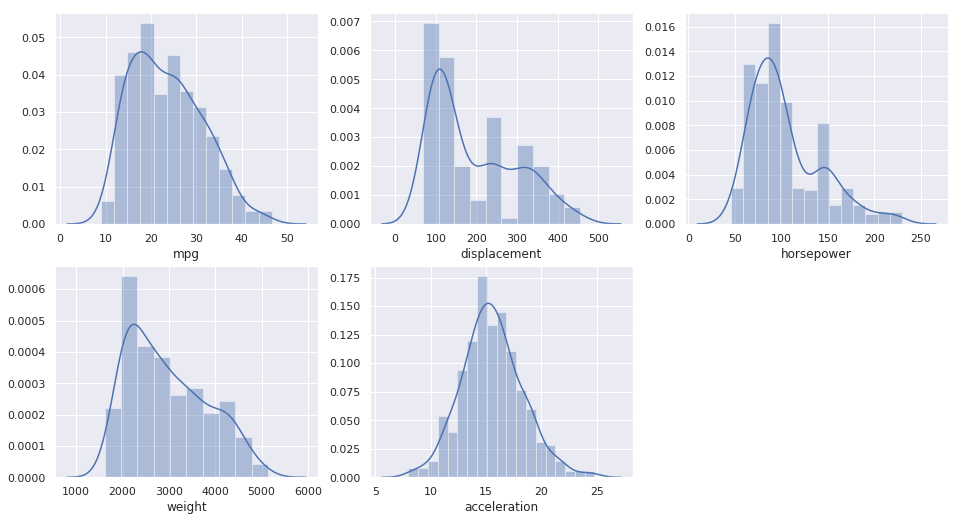

A **log-normal distribution** is a distribution of a random variable whose logarithm is normally distributed. Thus, if the random variable X is log-normally distributed, then Y = ln(X) has a normal distribution.

    We will check whether mpg and weight are log-normal or not.

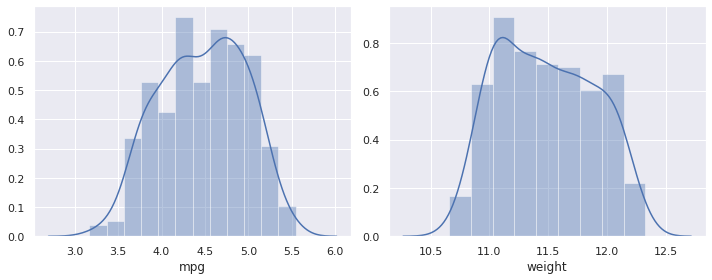

In [26]:
fig = pyplot.figure(1, (10, 4))

ax = pyplot.subplot(1,2,1)
sns.distplot(np.log2(df.mpg))
pyplot.tight_layout()

ax = pyplot.subplot(1,2,2)
sns.distplot(np.log2(df.weight))
pyplot.tight_layout()

pyplot.show()

So after applying log transformation we find that weight is not log-normal but mpg visually **looks like log-normal**.

    Let's check for normality using quantile-quantile plots.

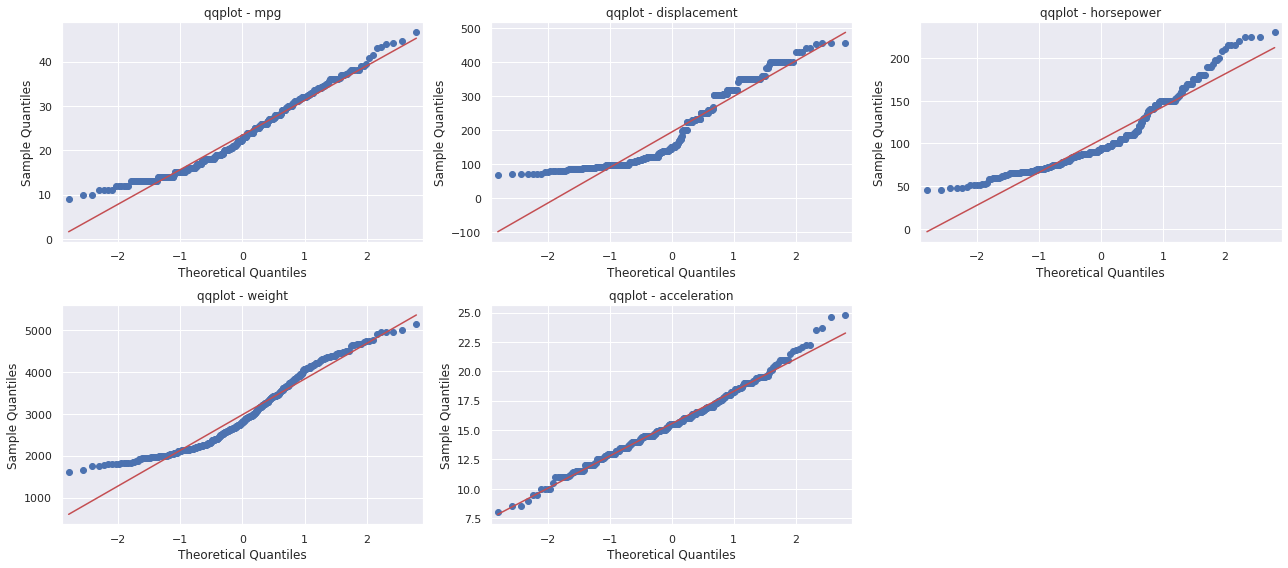

In [27]:
# quantile-quantile plots on original data
fig = pyplot.figure(1, (18,8))

for i,num in enumerate(nums):
    ax = pyplot.subplot(2,3,i+1)
    qqplot(df[num], line= 's', ax=ax)
    ax.set_title(f'qqplot - {num}')
    pyplot.tight_layout()

    so both histplot & qqplot of `acceleration` indicates that it is indeed close to gaussian.

### Statistical Normality Tests

We will do hypothesis testing for the normality of numerical attributes using the `shapiro wilk test`.<br>

&emsp;&emsp;&emsp;$H_{0}$: Data is drawn from normal distribution. &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $\alpha=0.05$

In [28]:
# let's contruct a function
def shapiro_wilk_test(df: pd.DataFrame, cols: list, alpha=0.05):
    # test the null hypothesis for columns given in `cols` of the dataframe `df` under significance level `alpha`.
    for col in cols:
        _,p = stats.shapiro(df[col])
        if p <= alpha:
            print(f'''\nRejected H0 under significance level {alpha}\n{col} doesn't seems to be normally distributed''')
        else:
            print(f'''\nFail to reject H0 due to lack of evidence under significance level {alpha}\n{col} seem to be normally distributed''')

In [29]:
shapiro_wilk_test(df, nums)


Rejected H0 under significance level 0.05
mpg doesn't seems to be normally distributed

Rejected H0 under significance level 0.05
displacement doesn't seems to be normally distributed

Rejected H0 under significance level 0.05
horsepower doesn't seems to be normally distributed

Rejected H0 under significance level 0.05
weight doesn't seems to be normally distributed

Rejected H0 under significance level 0.05
acceleration doesn't seems to be normally distributed


Ooops, we expected acceleration to be normally distributed but are test rejected it, let's check the p-value.

In [30]:
_, p = stats.shapiro(df.acceleration)
p

0.03054318018257618

So we rejected it under the significance level of 5% but if it was 2.5% then we would have failed to reject the null-hypothesis. We won't change the p-value now otherwise it will be **p-hacking**. One possible reason for the rejection of $H_{0}$ is maybe our data is not scaled and I think scaling it helps.

We will now apply `power transform` to **make the data more gaussian like**. And after that check for normality on the transformed data.

**Power Transform**: It transforms data featurewise to make it more Gaussian-like. Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired just like here.


In [31]:
df_tfnum = pd.DataFrame(PowerTransformer().fit_transform(df[nums]), columns=nums)
df_tfnum.head()

/home/winter_soilder/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


,mpg,displacement,horsepower,weight,acceleration
0,-0.635451,1.119336,0.854984,0.0,-1.317572
1,-1.142697,1.324530,1.443754,0.0,-1.522941
2,-0.635451,1.175211,1.216062,0.0,-1.732292
3,-0.965340,1.103648,1.216062,0.0,-1.317572
4,-0.796543,1.093078,1.044925,0.0,-1.945873


**Note**: on removing `nans` from the dataframe the power transformer is making the entire weight column 0. I am unable to find the reason for this and asked the sklearn community and update the notebook once I figured this out. If you detect the reason for that then please comment.

For now we will leave `weight`.

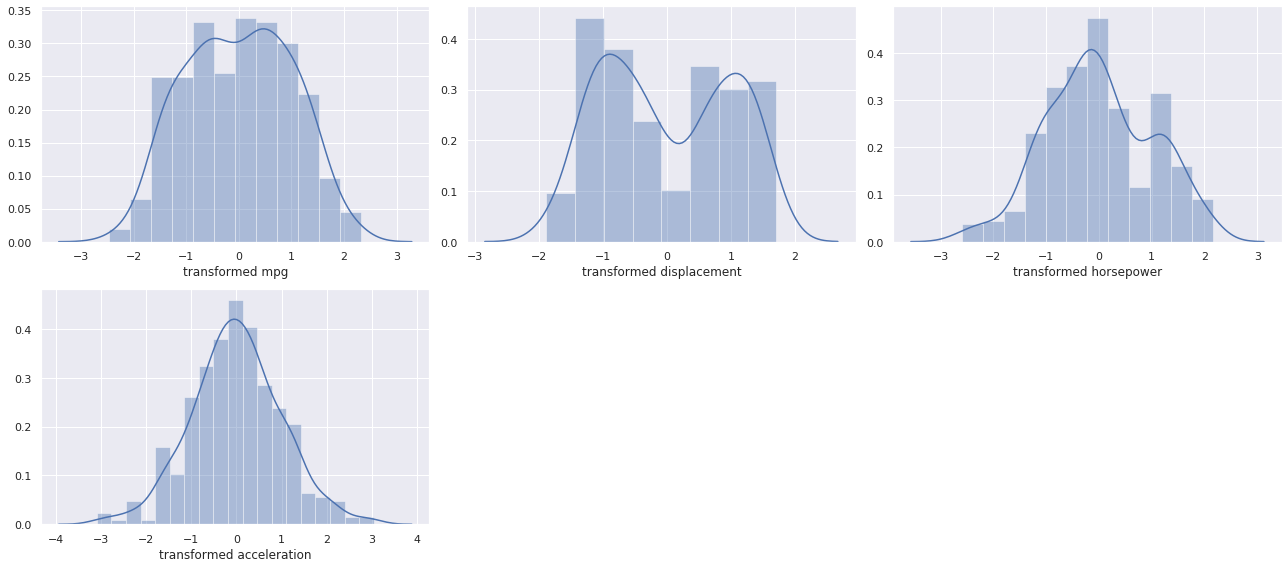

In [32]:
fig = pyplot.figure(1, (18,8))

for i,num in enumerate(['mpg', 'displacement', 'horsepower', 'acceleration']):
    ax = pyplot.subplot(2,3,i+1)
    sns.distplot(df_tfnum[num])
    ax.set_xlabel(f'transformed {num}')
    pyplot.tight_layout()

Power transforms does two things, first it scaled the data i.e., now data is centered at 0 and also made the distribution more gaussian-like simultaneously preserving the original structure. It does so by applying transformations like square-root, log etc.

`acceleration` is still gaussian, skewness is removed from `mpg` & `weight` making mpg gaussian-like. Also the distribution for `displacement` is improved now it's bimodal which respects the observation.

One thing you have noticed that after applying power transform distribution of `mpg` & `weight` is quite similar to what we get on applying log transform. Infact the power transform of sklearn indeed applies log transforms, refer [this](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-transformer).

    Let's check for normality using quantile-quantile plots.

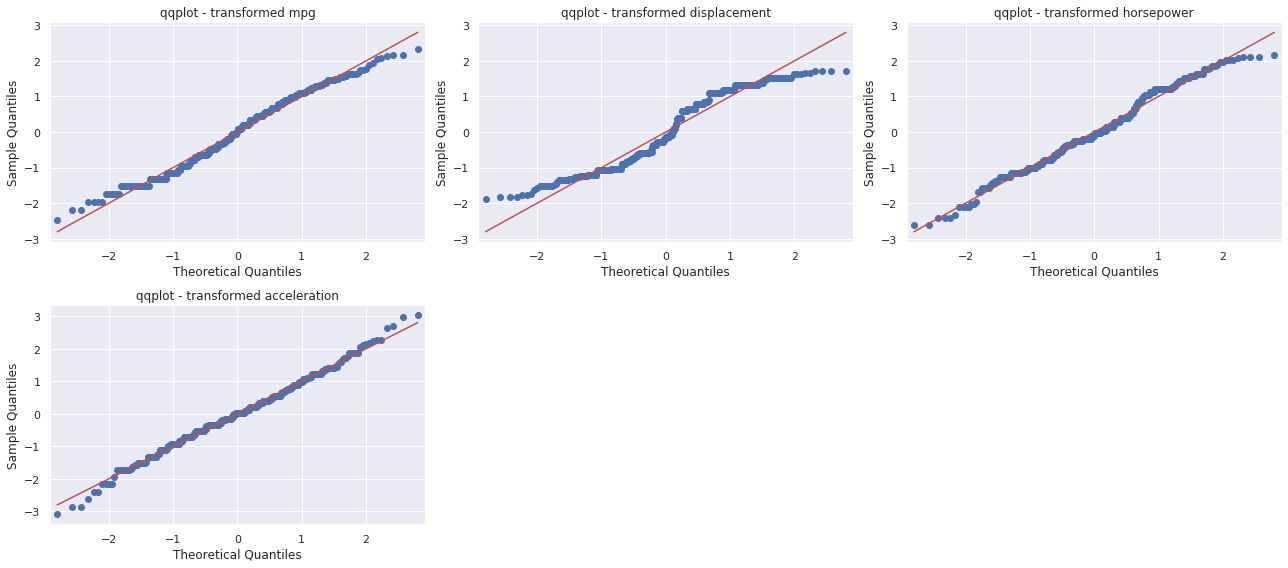

In [33]:
# quantile-quantile plots on transformed data
fig = pyplot.figure(1, (18,8))

for i,num in enumerate(['mpg', 'displacement', 'horsepower', 'acceleration']):
    ax = pyplot.subplot(2,3,i+1)
    qqplot(df_tfnum[num], line='s', ax=ax)
    ax.set_title(f'qqplot - transformed {num}')
    pyplot.tight_layout()

In [34]:
shapiro_wilk_test(df_tfnum, ['mpg', 'displacement', 'horsepower', 'acceleration'])


Rejected H0 under significance level 0.05
mpg doesn't seems to be normally distributed

Rejected H0 under significance level 0.05
displacement doesn't seems to be normally distributed

Rejected H0 under significance level 0.05
horsepower doesn't seems to be normally distributed

Fail to reject H0 due to lack of evidence under significance level 0.05
acceleration seem to be normally distributed


In [35]:
_, p = stats.shapiro(df_tfnum.acceleration)
p

0.3864997923374176

Indeed on normalizing the data the likelihood of observing `acceleration` assuming it's normal is very high as compared to earlier.

    So `acceleration` is normally distributed both visually and statistically.

Un-normalized data can sometimes lead to some wrong insights also. For eg,

In [**Part1-EDA**](https://www.kaggle.com/gauravsharma99/eda-on-mpg-data/) we ploted the relationship and from these plots it's seems that although all the attributes have a monotonic relation with `mpg` but the relations are not seeming exactly linear.

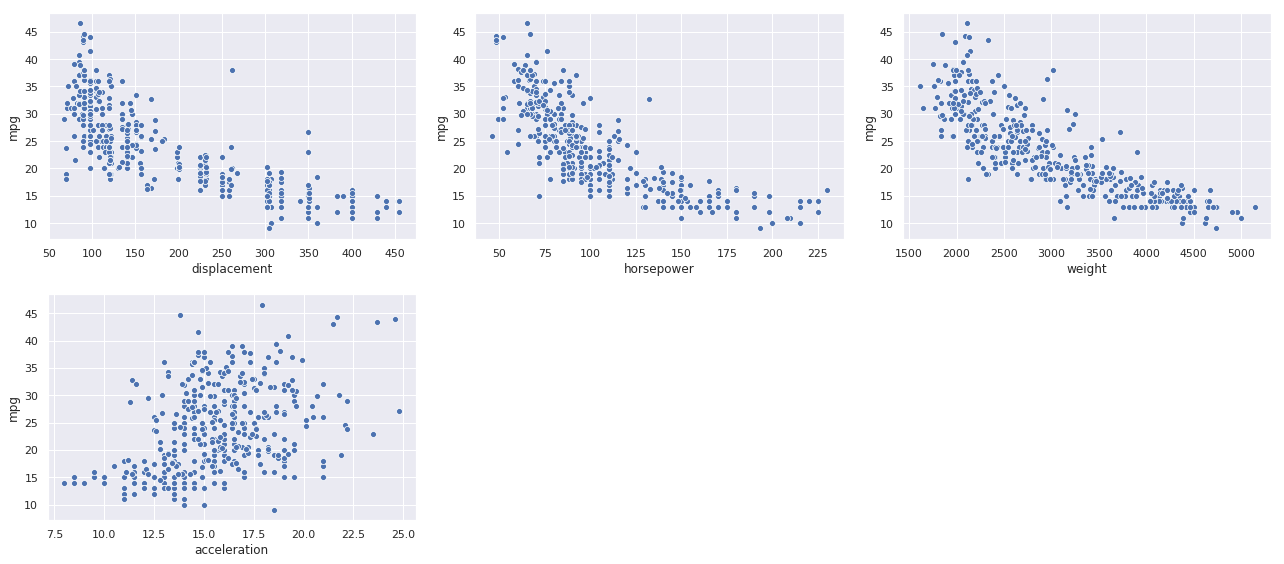

But in tranformed data all relations are purely linear.
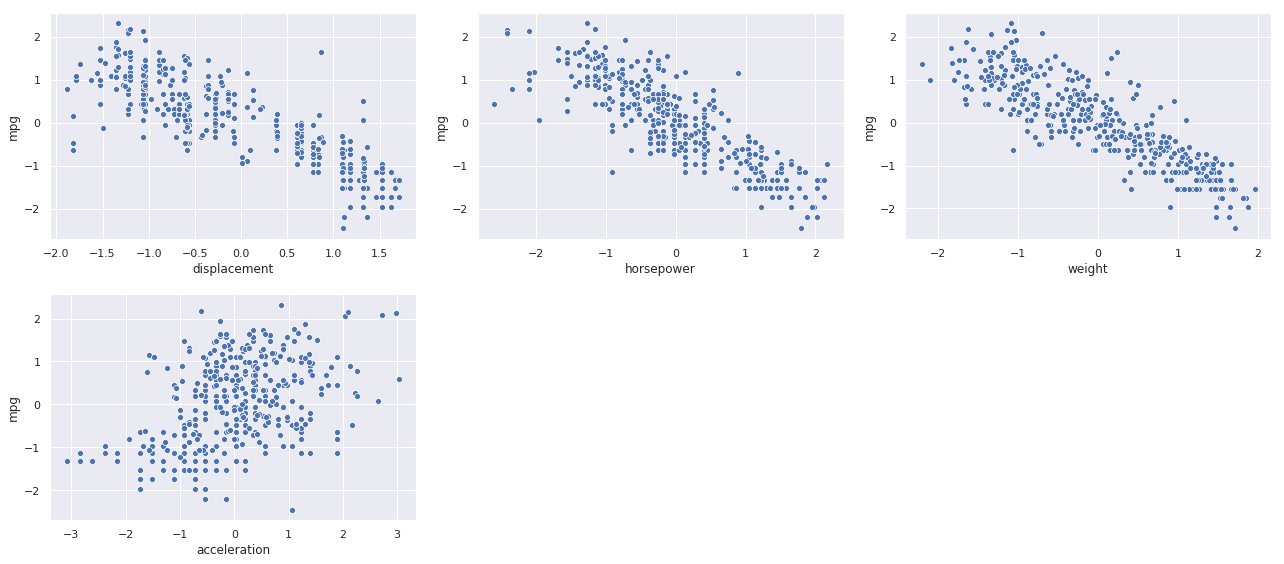

**Note:** Almost everyone is **homoscedastic** but acceleration is bit more **hetro** seeming.

## Tests for correlation between two continous variables

### Covariance

$$\large Cov(x,y) = \frac{\sum (x_{_i}-\bar{x})(y_{_i}-\bar{y})}{n-1}$$

The use of the mean in the calculation suggests the need for each data sample to have a Gaussian or Gaussian-like distribution hence its **parametric statistic**. Also it's hard to interpret because it can take any value.

## Linear Association (Pearson's Correlation)

$$\large Corr_{_p}(x,y) = \frac{Cov(x,y)}{\sigma _{x}\sigma _{y}}$$

The Pearson correlation coefficient is just a **normalized covariance** between the two variables to give an interpretable score such that $Corr_{p}(x,y)\in [-1,1]$. It can be used to summarize the strength of the linear relationship between two data samples. The use of mean and standard deviation in the calculation suggests the need for the two data samples to have a Gaussian or Gaussian-like distribution hence it's a **parametric statistic**.

As a statistical hypothesis test, the method assumes that the samples are uncorrelated (fail to reject H0).

**Assumptions of pearson correlation**:<br>
&emsp;&emsp;&emsp;**1.** Both variables should have a Gaussian or Gaussian-like distribution.<br>
&emsp;&emsp;&emsp;**2.** Relationship between the variables should be linear.<br>
&emsp;&emsp;&emsp;**3.** Homoscedasticity i.e., a sequence of random variables where all its random variables have the same finite variance.<br>

Also Pearson is quite sensitive to outliers.<br>

Two variables may be related by a nonlinear relationship, such that the relationship is stronger or weaker across the distribution of the variables. In these cases, even when variables have a strong association, Pearson’s correlation would be low. Further, the two variables being considered may have a non-Gaussian distribution. To properly identify association between variables with non-linear relationships, we can use rank-based correlation approaches.

## Ordinal Association (Rank correlation)
Rank correlation refers to methods that quantify the association between variables using the ordinal relationship between the values rather than the specific values. In this we first sort data in ascending order, then assign integer rank to them and then use it to find the correlation b/w variables. Because no distribution for the values is assumed, rank correlation methods are referred to as distribution-free correlation or nonparametric correlation. 

Four types of rank correlation methods are as follows:

### 1. Spearman's Rank Correlation

$$\large Corr_{_s}(x,y) = \frac{Cov(rank(x), rank(y))}{\sigma _{rank(x)}\sigma _{rank(y)}}$$

Spearman's Correlation is a **non-parametric rank correlation** and is also interpretable because $Corr_{s}(x,y)\in [-1,1]$. In this instead of calculating the coefficient using covariance and standard deviations on the samples themselves, these statistics are calculated by converting the raw data into rank data hence non-parametric. **This is a common approach used in non-parametric statistics.**

As a statistical hypothesis test, the method assumes that the samples are uncorrelated (fail to reject H0).

### 2. Kendall’s Rank Correlation
The intuition for the test is that it calculates a normalized score for the number of matching or concordant rankings between the two samples. As such, the test is also referred to as Kendall’s concordance test.

As a statistical hypothesis test, the method assumes that the samples are uncorrelated (fail to reject H0).

### 3. Goodman and Kruskal’s Rank Correlation
### 4. Somers’ Rank Correlation

**Types of Correlation**:<br>
&emsp;&emsp;&emsp;**Positive:** both variables change in the same direction.<br>
&emsp;&emsp;&emsp;**Neutral:** no relationship in the change of the variables.<br>
&emsp;&emsp;&emsp;**Negative:** variables change in opposite directions.

The statistical test only tells the likelihood of an effect. It doesn't tell us the size of the effect. The results of an experiment could be significant, but the effect so small that it has little consequence or the result could be insignificant, but the effect is large.

**Effect size:** It is the size or magnitude of an effect or result as it would be expected to occur in a population. Unlike **significance tests** which just tells how likely is the effect, **effect size** actually tells the value of the effect occurred. So it gives us more power.

**We will find the effect test for the relation of `mpg` with other numercal features**. i.e., we will be getting an absolute value instead of likelihood which quantify how much correlation is there b/w `mpg` and other numerical features.

But all the above association tests not only gives the effect size but also the p-value. So can look at both the values. We will be using `spearman` but you can use any other accept `pearson` because all numerical variables doesn't satisfies the pearson's assumptions.<br>

So for all correlation test b/w mpg and other attribute our null hypothesis will be,

&emsp;&emsp;&emsp;$H_{0}$: `mpg` and `other attribute` are not correlated. &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $\alpha=0.05$

In [36]:
for num in nums:
    if num == 'mpg':
        continue
    
    corr, p = stats.spearmanr(df.mpg, df[num])

    print(f'\n* `mpg` & `{num}`\n')
    print(f'corr: {round(corr, 4)} \t p: {p}')

    if p <= ALPHA:
        print(f'Rejected H0 under significance level {ALPHA}, mpg & {num} are correlated')
    else:
        print(f'''Fail to reject H0 due to lack of evidence under significance level {ALPHA}, 
              mpg & {num} are not correlated''')


* `mpg` & `displacement`

corr: -0.8552 	 p: 2.1957775993226176e-113
Rejected H0 under significance level 0.05, mpg & displacement are correlated

* `mpg` & `horsepower`

corr: -0.8536 	 p: 1.619383245501938e-112
Rejected H0 under significance level 0.05, mpg & horsepower are correlated

* `mpg` & `weight`

corr: -0.8756 	 p: 2.662377938025222e-125
Rejected H0 under significance level 0.05, mpg & weight are correlated

* `mpg` & `acceleration`

corr: 0.4415 	 p: 3.9036035663531793e-20
Rejected H0 under significance level 0.05, mpg & acceleration are correlated


    So all the H0 are rejected under the significance level of 5%. Accept `acceleration` all the other correlations are very high and  this is also evident from our previous plots.
    
We now create a dataframe for the correlation b/w every pair.

In [37]:
def test_correlation(x1, x2, method='spearman', alpha=0.05):
    # this function returns correlation, p-value and H0 for `x1` & `x2`
    
    ALLOWED_METHODS = ['pearson', 'spearman', 'kendall']
    if method not in ALLOWED_METHODS:
        raise ValueError(f'allowed methods are {ALLOWED_METHODS}')
        
    if method=='pearson':
        corr, p = stats.pearsonr(x1,x2)
    elif method=='spearman':
        corr, p = stats.spearmanr(x1,x2)
    else:
        corr, p = stats.kendalltau(x1,x2)
    
    h0 = (
    'rejected'
    if p<=ALPHA else
    'fail to reject')
    
    return corr, p, h0

In [38]:
df_corr = pd.DataFrame(columns=['attr1', 'attr2', 'corr', 'p', 'H0'])

for combo in itertools.combinations(nums, r=2):
    corr, p, h0 = test_correlation(df[combo[0]], df[combo[1]])
    df_corr = df_corr.append({'attr1':combo[0], 'attr2':combo[1],
                              'corr':round(corr, 5), 'p':p, 'H0':h0}, ignore_index=True)
    
df_corr

,attr1,attr2,corr,p,H0
0,mpg,displacement,-0.85523,2.195778e-113,rejected
1,mpg,horsepower,-0.85362,1.619383e-112,rejected
2,mpg,weight,-0.87559,2.662378e-125,rejected
3,mpg,acceleration,0.44154,3.903604e-20,rejected
4,displacement,horsepower,0.87617,1.126737e-125,rejected
5,displacement,weight,0.94563,2.463170e-192,rejected
6,displacement,acceleration,-0.49940,4.061210e-26,rejected
7,horsepower,weight,0.87882,2.182674e-127,rejected
8,horsepower,acceleration,-0.65814,5.157840e-50,rejected
9,weight,acceleration,-0.40511,6.484246e-17,rejected


Correlation of pairs (mpg, acceleration), (displacement, acceleration) and (weight, acceleration) is moderate whereas remaining all pairs has very high correlation between them.

We will now test whether two samples has the same mean or not. For this we have two types of significance tests for two different conditions.

### Parametric Statistical Significance Tests
1. **Student’s t-test** - It tests whether the two independent normal distributed samples has the same mean or not.
2. **Analysis of Variance Test (ANOVA)** - It tests whether the two or more independent normal distributed samples has the same mean or not.

ANOVA is same as t-test but for more than 2 variables. So either we can apply t-test pair-wise of apply ANOVA once. Also ANOVA only tells whether all samples are same or not, it doesn't quantify which samples differ or by how much.

### Non-Parametric Statistical Significance Tests
1. **Mann-Whitney U Test** - Non-parameetric equivalent of Student's t-test.
2. **Kruskal-Wallis H** - Non-parameetric equivalent of ANOVA (it's for median).

We will apply appropriate test depending on the sample, i.e., if samples are normally distributed then parametric tests otherwise non-parametric tests.

    Let's test whether acceleration in `japan` and `usa` has the same mean.
    
First we check whether acceleration of both japan and usa are normally distributed or not and then apply the applicable tests.

In [39]:
shapiro_wilk_test(df[df.origin=='japan'], ['acceleration'])


Fail to reject H0 due to lack of evidence under significance level 0.05
acceleration seem to be normally distributed


In [40]:
shapiro_wilk_test(df[df.origin=='usa'], ['acceleration'])


Fail to reject H0 due to lack of evidence under significance level 0.05
acceleration seem to be normally distributed


    So both are normally distributed so we can apply parametric test.
    
&emsp;&emsp;&emsp;$H_{0}$: `acceleration of japan` and `acceleration of usa` has same sample mean. &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $\alpha=0.05$

In [41]:
# because the variance is not same for the two distributions hence equal_var=False
_, p = stats.ttest_ind(df[df.origin=='japan'].acceleration, df[df.origin=='usa'].acceleration, equal_var=False)

if p <= ALPHA:
    print(f'Rejected H0 under {ALPHA*100}% significance, Different distributions.')
else:
    print(f'Fail to Reject H0 under {ALPHA*100}% significance, Same distributions.')

Rejected H0 under 5.0% significance, Different distributions.


In [42]:
_, p = stats.f_oneway(df[df.origin=='japan'].acceleration, df[df.origin=='usa'].acceleration, df[df.origin=='europe'].acceleration)

if p <= ALPHA:
    print(f'Rejected H0 under {ALPHA*100}% significance, Different distributions.')
else:
    print(f'Fail to Reject H0 under {ALPHA*100}% significance, Same distributions.')

Rejected H0 under 5.0% significance, Different distributions.


    Let's test whether horsepower across all the regions has the same distribution or not.

In [43]:
shapiro_wilk_test(df[df.origin=='japan'], ['horsepower'])


Rejected H0 under significance level 0.05
horsepower doesn't seems to be normally distributed


In [44]:
shapiro_wilk_test(df[df.origin=='europe'], ['horsepower'])


Rejected H0 under significance level 0.05
horsepower doesn't seems to be normally distributed


In [45]:
shapiro_wilk_test(df[df.origin=='usa'], ['horsepower'])


Rejected H0 under significance level 0.05
horsepower doesn't seems to be normally distributed


    So all of them are not normally distributed so we will apply non-parametric test.
    
&emsp;&emsp;&emsp;$H_{0}$: Sample distributions are equal for horsepower across region. &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $\alpha=0.05$

In [46]:
_, p = stats.kruskal(df[df.origin=='japan'].horsepower, df[df.origin=='usa'].horsepower, df[df.origin=='europe'].horsepower)

if p <= ALPHA:
    print(f'Rejected H0 under {ALPHA*100}% significance, Different distributions.')
else:
    print(f'Fail to Reject H0 under {ALPHA*100}% significance, Same distributions.')

Rejected H0 under 5.0% significance, Different distributions.


    Test whether acceleration has same distribution for samples with mpg_level high & medium.

In [47]:
_, p = stats.mannwhitneyu(df[df.mpg_level=='high'].acceleration, df[df.mpg_level=='medium'].acceleration)

if p <= ALPHA:
    print(f'Rejected H0 under {ALPHA*100}% significance, Different distributions.')
else:
    print(f'Fail to Reject H0 under {ALPHA*100}% significance, Same distributions.')

Rejected H0 under 5.0% significance, Different distributions.


    Test for mpg distribution across the years.

In [48]:
acc_gb_year = df.groupby('model_year')['mpg']

acc_yr = []
for yr in df.model_year.unique():
    acc_yr.append(list(acc_gb_year.get_group(yr)))

In [49]:
_, p = stats.kruskal(*acc_yr)

if p <= ALPHA:
    print(f'Rejected H0 under {ALPHA*100}% significance, Different distributions.')
else:
    print(f'Fail to Reject H0 under {ALPHA*100}% significance, Same distributions.')

Rejected H0 under 5.0% significance, Different distributions.


### Relation between Categorical and Continous attributes

In [50]:
# help(feature_selection.f_classif)
result_f = feature_selection.f_classif(df.loc[:, 'mpg': 'acceleration'], df.cylinders)
anova_test_cat = pd.DataFrame({
    'cat-attr': 'cylinders',
    'cont-attr': df.loc[:, 'mpg': 'acceleration'].columns,
    'f': result_f[0],
    'p': result_f[1],
    'alpha': ALPHA
})
anova_test_cat['H0'] = anova_test_cat.p.apply(lambda x: 'rejected' if x <= ALPHA else 'fail to reject')
anova_test_cat['relation'] = anova_test_cat.H0.apply(lambda x: 'dependent' if x=='rejected' else 'independent')
anova_test_cat

,cat-attr,cont-attr,f,p,alpha,H0,relation
0,cylinders,mpg,172.954629,8.785541e-85,0.05,rejected,dependent
1,cylinders,displacement,933.260216,3.054493e-197,0.05,rejected,dependent
2,cylinders,horsepower,297.855648,1.079822e-116,0.05,rejected,dependent
3,cylinders,weight,414.851887,1.751845e-138,0.05,rejected,dependent
4,cylinders,acceleration,48.677596,3.709542e-33,0.05,rejected,dependent


In [51]:
result_f = feature_selection.f_classif(df_cat_label[['origin', 'cylinders', 'model_year']], df.mpg)
anova_test_cat = pd.DataFrame({
    'cont-attr': 'mpg',
    'cat-attr': ['origin', 'cylinders', 'model_year'],
    'f': result_f[0],
    'p': result_f[1],
    'alpha': ALPHA
})
anova_test_cat['H0'] = anova_test_cat.p.apply(lambda x: 'rejected' if x <= ALPHA else 'fail to reject')
anova_test_cat['relation'] = anova_test_cat.H0.apply(lambda x: 'dependent' if x=='rejected' else 'independent')
anova_test_cat

,cont-attr,cat-attr,f,p,alpha,H0,relation
0,mpg,origin,2.345244,3.516516e-09,0.05,rejected,dependent
1,mpg,cylinders,12.104269,2.855307e-63,0.05,rejected,dependent
2,mpg,model_year,3.795294,3.748099e-20,0.05,rejected,dependent


So we are done for now. We did a lot and can extend it further but you get the idea. In the next part we will do some **predictive modelling**.

<span style="color:red">**If you like this notebook then please upvote and also share with others.**<span>

### References
The following material has been used as source and guidance-
* Data source:  https://archive.ics.uci.edu/ml/datasets/auto+mpg
* Statistical Methods for ML by Jason Brownlee. Most of the definations are taken from this awesome book.
* https://cyfar.org/what-data-analysis